In [1]:
import numpy as np
import scipy
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline

from numba import jit

In [2]:
# a), b)
def init_system(Lx, Ly):
    """Determine the bond array and an initial state of spins"""
    N = Lx * Ly

    def xy_to_n(x, y):
        return x*Ly + y

    def n_to_xy(n):
        return n // Ly, np.mod(n, Ly)

    # easy way:
    bonds = []
    for x in range(Lx):
        for y in range(Ly):
            n = xy_to_n(x, y)
            m1 = xy_to_n((x+1)% Lx, y)
            m2 = xy_to_n(x, (y+1) % Ly)
            bonds.append([n, m1])
            bonds.append([n, m2])
    bonds = np.array(bonds)
    spins = np.random.randint(0, 2, size=(N,))*2 - 1
    return spins, bonds, N


In [3]:
# part c)
@jit(nopython=True)
def get_weights(spins, bonds, T):
    weights = np.zeros(len(bonds))
    p = np.exp(-2./T)  # set J = 1
    for b in range(len(bonds)):
        n = bonds[b, 0]
        m = bonds[b, 1]
        #if spins[n] != spins[m]:
        #    weights[b] = 0.
        #else:
        #    if np.random.rand() < p:
        #        weights[b] = 0.
        #    else: 
        #        weights[b] = 1.
        if spins[n] == spins[m] and np.random.rand() > p:
            weights[b] = 1.
    return weights

In [4]:
# part d)
@jit(nopython=True)
def flip_spins(spins, N_components, labels):
    flip_cluster = np.random.random(N_components) < 0.5   # N_components True/False values with 50/50 chance
    for n in range(len(spins)):
        cluster = labels[n]
        if flip_cluster[cluster]:
            spins[n] = - spins[n]
    # done

In [5]:
def swendsen_wang_update(spins, bonds, T):
    """Perform one update of the Swendsen-Wang algorithm"""
    N = len(spins)
    weights = get_weights(spins, bonds, T)
    graph = csr_matrix((weights, (bonds[:, 0], bonds[:, 1])), shape=(N, N))
    graph += csr_matrix((weights, (bonds[:, 1], bonds[:, 0])), shape=(N, N))
    N_components, labels = connected_components(graph, directed=False)
    flip_spins(spins, N_components, labels)

In [6]:
@jit(nopython=True)
def energy(spins, bonds):
    Nbonds = len(bonds)
    energy = 0.
    for b in range(Nbonds):
        energy -= spins[bonds[b, 0]]* spins[bonds[b, 1]]
    return energy

def energy2(spins, bonds):
    """alternative implementation, gives the same results, but does not require jit to be fast"""
    return -1. * np.sum(spins[bonds[:, 0]]* spins[bonds[:, 1]])

def magnetization(spins):
    return np.sum(spins)
       

In [7]:
def simulation(spins, bonds, T, N_measure=100):
    """Perform a Monte-carlo simulation at given temperature"""
    # thermalization: without measurement
    for _ in range(N_measure//10):
        swendsen_wang_update(spins, bonds, T)
    Es = []
    Ms = []
    for n in range(N_measure):
        swendsen_wang_update(spins, bonds, T)
        Es.append(energy(spins, bonds))
        Ms.append(magnetization(spins))
    return np.array(Es), np.array(Ms)
        
        

In [8]:
# The full simulation at different temperatures
def run(Ts, L, N_measure=100):
    spins, bonds, N = init_system(L, L)
    spins = np.random.randint(0, 2, size=(N,))*2 - 1
    Ms = []
    absMs = []
    Es = []
    Cs = []
    for T in Ts:
        #print("simulating T = ", T, flush=True)
        E, M = simulation(spins, bonds, T, N_measure)
        Es.append(np.mean(E)/N)
        Cs.append(np.var(E)/(T**2*N))
        Ms.append(np.mean(M)/N)
        absMs.append(np.mean(np.abs(M))/N)
    return Es, Cs, Ms, absMs

calculate L = 4
   took 47.1 seconds
calculate L = 8
   took 47.1 seconds
calculate L = 16
   took 48.0 seconds
calculate L = 32
   took 55.0 seconds
done


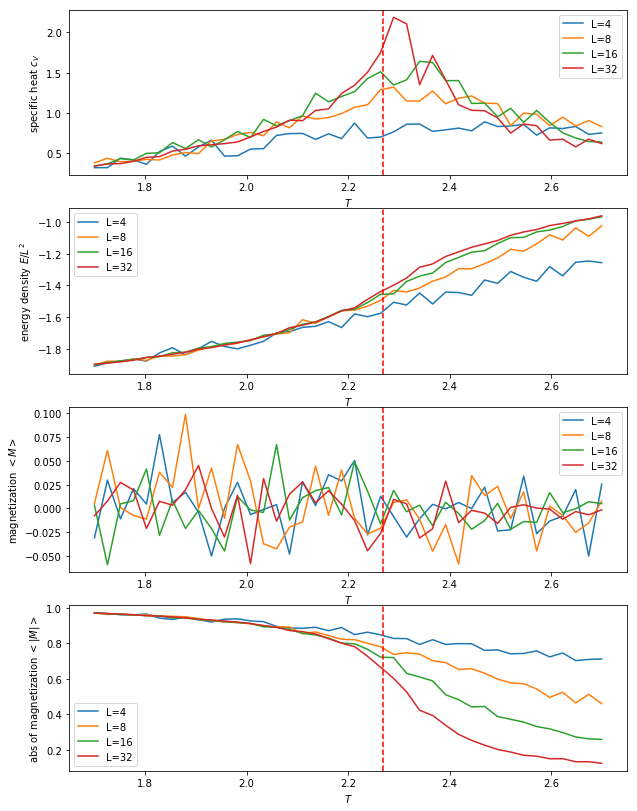

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(10, 14))
ax1, ax2, ax3, ax4 = axes
Tc = 2. / np.log(1. + np.sqrt(2))
Ts = np.linspace(2.7, 1.7, 40)

print("warning: this takes some time")
for L in [4, 8, 16, 32]:
    print("calculate L =", L, flush=True)
    t0 = time.time()
    Es, Cs, Ms, absMs = run(Ts, L, N_measure=1000)
    # Plot the results
    ax1.plot(Ts, Cs, label='L={L:d}'.format(L=L))
    ax2.plot(Ts, Es, label='L={L:d}'.format(L=L))
    ax3.plot(Ts, Ms, label='L={L:d}'.format(L=L))
    ax4.plot(Ts, absMs, label='L={L:d}'.format(L=L))
    print("   took {t:.1f} seconds".format(t=time.time()-t0), flush=True)


for ax in axes:
    ax.axvline(Tc, color='r', linestyle='--')
    ax.set_xlabel('$T$')
    ax.legend(loc='best')

ax1.set_ylabel('specific heat $c_V$')
ax2.set_ylabel('energy density $E/L^2$')
ax3.set_ylabel('magnetization $<M>$')
ax4.set_ylabel('abs of magnetization $<|M|>$')
print("done")


## Auto-correlation time

In [10]:
def auto_correlation(E, delta):
    if delta == 0:
        return 1.
    N = len(E)
    dE = E - np.mean(E)
    cor = np.mean(dE[delta:] * dE[:-delta]) / np.mean(dE**2)
    return cor

T= 2.0
T= 2.269185314213022
T= 3.0


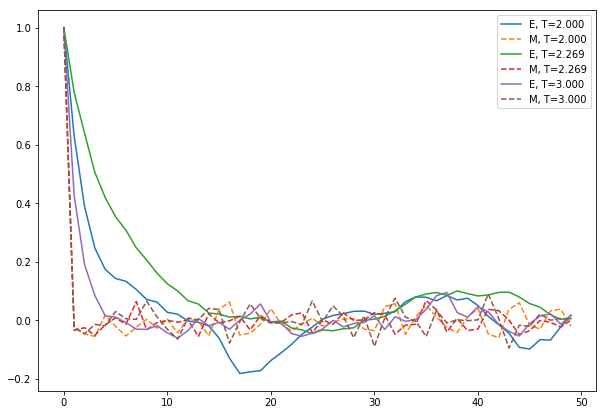

In [11]:
L = 64
spins, bonds, N = init_system(L, L)
deltas = np.arange(0, 50)

plt.figure(figsize=(10, 7))
for T in [2., Tc, 3.]:
    print("T=", T, flush=True)
    E, M = simulation(spins, bonds, T, 1000)
    cor_E = [auto_correlation(E, d) for d in deltas]
    cor_M = [auto_correlation(M, d) for d in deltas]
    plt.plot(deltas, cor_E, label="E, T={T:.3f}".format(T=T))
    plt.plot(deltas, cor_M, linestyle='--', label="M, T={T:.3f}".format(T=T))
plt.legend()

plt.show()


## compare with auto correlation of Metropolis 

In [12]:
def bonds_alternative(Lx, Ly):
    N = Lx * Ly

    def xy_to_n(x, y):
        return x*Ly + y

    bonds_alt = []
    for x in range(Lx):
        for y in range(Ly):
            n = xy_to_n(x, y)
            m1 = xy_to_n((x+1)% Lx, y)
            m2 = xy_to_n(x, (y+1) % Ly)
            m3 = xy_to_n((x-1)% Lx, y)
            m4 = xy_to_n(x, (y-1) % Ly)
            bonds_alt.append([m1, m2, m3, m4])
    return np.array(bonds_alt)

@jit(nopython=True)
def delta_E(spins, bonds_alt, n):
    z = bonds_alt.shape[1]
    s = 0.
    for i in range(z):
        s += spins[bonds_alt[n, i]]
    return -spins[n] * s

@jit(nopython=True)
def metropolis_update(spins, bonds, bonds_alt, T):
    N = len(spins)
    E = energy(spins, bonds)
    for _ in range(N):
        n = np.random.randint(0, N)
        dE = -2. * delta_E(spins, bonds_alt, n)
        if np.random.rand() < np.exp(-dE/T):
            spins[n] *= -1
            E += dE
    # done

def simulation_metropolis(spins, bonds, bonds_alt, T, N_measure=100):
    """Perform a Monte-carlo simulation at given temperature"""
    # thermalization: without measurement
    for _ in range(N_measure//10):
        metropolis_update(spins, bonds, bonds_alt, T)
    Es = []
    Ms = []
    for n in range(N_measure):
        metropolis_update(spins, bonds, bonds_alt, T)
        Es.append(energy(spins, bonds))
        Ms.append(magnetization(spins))
    return np.array(Es), np.array(Ms)
    

T= 2.0
T= 2.269185314213022
T= 3.0


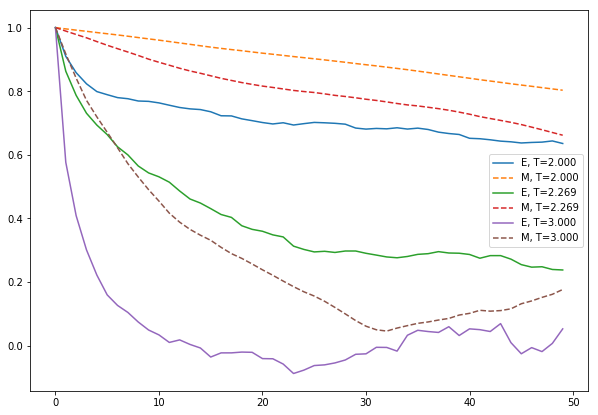

In [13]:
spins, bonds, N = init_system(L, L)
bonds_alt = bonds_alternative(L, L)

plt.figure(figsize=(10, 7))
for T in [2., Tc, 3.]:
    print("T=", T, flush=True)
    E, M = simulation_metropolis(spins, bonds, bonds_alt, T, 1000)
    cor_E = [auto_correlation(E, d) for d in deltas]
    cor_M = [auto_correlation(M, d) for d in deltas]
    plt.plot(deltas, cor_E, label="E, T={T:.3f}".format(T=T))
    plt.plot(deltas, cor_M, linestyle='--', label="M, T={T:.3f}".format(T=T))
plt.legend()

plt.show()


## checks for debugging

In [14]:
L = 64
spins, bonds, N = init_system(L, L)

In [15]:
E, M = simulation(spins, bonds, 2., N_measure=10)
print(M)
print(E)

[  334   842   972  3180 -3352  3528  3640  3678 -3718  3750]
[-4128. -4948. -5760. -6404. -6804. -6884. -6896. -7048. -7004. -7112.]


In [16]:
T = 0.1
print(spins)
for i in range(100):
    swendsen_wang_update(spins, bonds, T)
print(spins)
print(energy(spins, bonds))
assert(energy(spins, bonds) == energy2(spins, bonds))
print(magnetization(spins))

[ 1  1  1 ...  1  1 -1]
[-1 -1 -1 ... -1 -1 -1]
-8192.0
-4096


In [17]:
%%timeit
swendsen_wang_update(spins, bonds, 1.)


1.7 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
